In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.mnist import MNIST
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [2]:
batch_size = 32
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader

In [4]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin, scale):
        """
        ArcFace: Additive Angular Margin Loss for Deep Face Recognition
        (https://arxiv.org/pdf/1801.07698.pdf)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
            margin: m in the paper, the angular margin penalty in radians
            scale: s in the paper, feature scale
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return nn.CrossEntropyLoss()(logits, labels)
        
    def get_cosine(self, embeddings):
        """
        Args:
            embeddings: (None, embedding_size)
        Returns:
            cosine: (None, n_classes)
        """
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
        """
        Args:
            labels: (None,)
        Returns:
            mask: (None, n_classes)
        """
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        """
        Args:
            cosine_of_target_classes: (None,)
        Returns:
            modified_cosine_of_target_classes: (None,)
        """
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        """
        Args:
            logits: (None, n_classes)
        Returns:
            scaled_logits: (None, n_classes)
        """
        return logits * self.scale
    
class SoftmaxLoss(nn.Module):
    def __init__(self, num_classes, embedding_size):
        """
        Regular softmax loss (1 fc layer without bias + CrossEntropyLoss)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        logits = F.linear(embeddings, self.W)
        return nn.CrossEntropyLoss()(logits, labels)

In [5]:
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # (None, 16, 5, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, embedding_size, loss_type, max_epochs):
        super().__init__()
        self.save_hyperparameters('max_epochs')
        self.embedder = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.LazyLinear(100),
            nn.ReLU(),
            nn.LazyLinear(embedding_size)
        )
        
        if loss_type == 'arcface':
            self.loss_function = ArcFaceLoss(
                num_classes=10, 
                embedding_size=embedding_size,
                margin=0.3, 
                scale=30.0
            )
        elif loss_type == 'softmax':
            self.loss_function = SoftmaxLoss(num_classes=10, embedding_size=embedding_size)
           
    def forward(self, x):
        return self.embedder(x) # (None, embedding_size)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        embeddings = self.embedder(x) # (None, embedding_size)
        loss = self.loss_function(embeddings, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        embeddings = self.embedder(x) # (None, embedding_size)
        return {'embeddings': embeddings, 'labels': y}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [6]:
def visualize(trainer, model, loader, title):
    outputs = trainer.predict(model, loader)
    embeddings = F.normalize(torch.cat([output['embeddings'] for output in outputs])).numpy()
    labels = torch.cat([output['labels'] for output in outputs]).numpy()
    
    colors = ["red", "black", "yellow", "green", "pink",
              "gray", "lightgreen", "orange", "blue", "teal"]

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings[:,0], embeddings[:,1], 
                color=[colors[label] for label in labels])
    ax = plt.gca()
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.show()

/home/ielab/anaconda3/envs/arcface/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ielab/anaconda3/envs/arcface/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:410: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name          | Type        | Params
----------------------------------------------
0 | embedder      | Sequential  | 2.9 K 
1 | loss_function | ArcFaceLoss | 5.1 K 
----------------------------------------------
8.0 K     Tr

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 1563it [00:00, ?it/s]

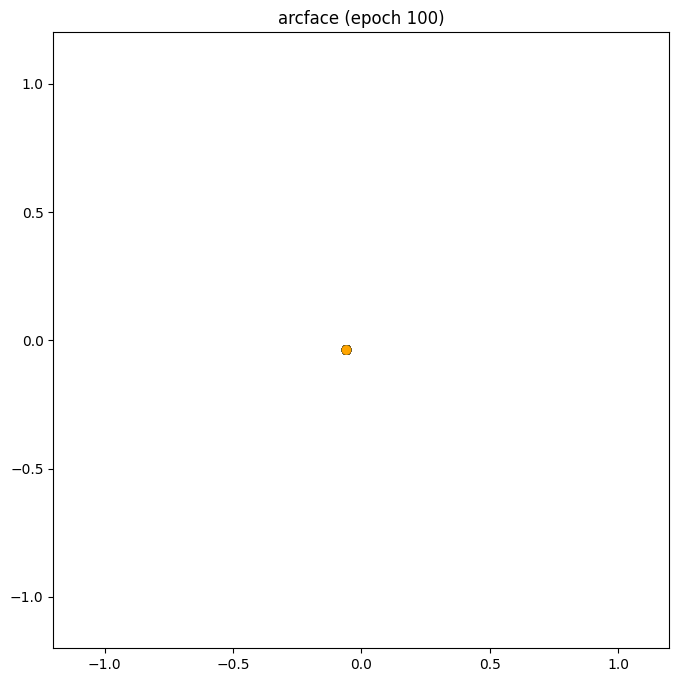

In [7]:
embedding_size = 512
max_epochs = 100
arcface_model = Model(embedding_size=embedding_size, loss_type='arcface', max_epochs=max_epochs)


arcface_trainer = pl.Trainer(accelerator="gpu", devices=1, log_every_n_steps=10, max_epochs=max_epochs)
arcface_trainer.fit(arcface_model, train_loader)
visualize(arcface_trainer, arcface_model, val_loader, f'arcface (epoch {max_epochs})')

In [1]:
a = torch.Tensor

NameError: name 'torch' is not defined

In [8]:
import plotly.express as px

In [9]:
def visual3d(trainer, model, loader, title):
    outputs = trainer.predict(model, loader)
    embeddings = F.normalize(torch.cat([output['embeddings'] for output in outputs])).numpy()
    labels = torch.cat([output['labels'] for output in outputs]).numpy()
    
    tsne_df = pd.DataFrame(
        np.column_stack((embeddings, labels)),
        columns = ["x","y","z","targets"]
    )

    fig = px.scatter_3d(tsne_df, x='x', y='y', z='z',
                  color='targets')
    fig.show()

In [10]:
visual3d(arcface_trainer, arcface_model, val_loader, f'arcface (epoch {max_epochs})')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 1563it [00:00, ?it/s]

ValueError: Shape of passed values is (10000, 513), indices imply (10000, 4)

In [11]:
def test(trainer, model, loader, title):
    outputs = trainer.predict(model, loader)
    embeddings = F.normalize(torch.cat([output['embeddings'] for output in outputs])).numpy()
    labels = torch.cat([output['labels'] for output in outputs]).numpy()
    
    print(embeddings)
    print(type(embeddings))
    print(embeddings.shape)
    print(embeddings[0])

test(arcface_trainer, arcface_model, val_loader, f'arcface (epoch {max_epochs})')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 1563it [00:00, ?it/s]

[[-0.05811983 -0.03804059  0.03145459 ...  0.03714435  0.06093874
  -0.05402192]
 [-0.05811903 -0.0380403   0.03145385 ...  0.03714465  0.0609387
  -0.0540222 ]
 [-0.05811908 -0.03804024  0.03145453 ...  0.03714395  0.0609386
  -0.05402212]
 ...
 [-0.05811938 -0.03804059  0.03145479 ...  0.03714392  0.06093816
  -0.05402228]
 [-0.05811884 -0.03804064  0.03145443 ...  0.03714402  0.06093825
  -0.05402256]
 [-0.05811922 -0.03804031  0.0314545  ...  0.03714432  0.06093856
  -0.05402196]]
<class 'numpy.ndarray'>
(10000, 512)
[-5.81198260e-02 -3.80405895e-02  3.14545929e-02 -4.04466363e-03
  3.53434794e-02  1.43111283e-02  3.32801640e-02  5.54810204e-02
  1.80661818e-03 -7.02690333e-02 -6.95419908e-02  6.12184852e-02
 -4.50285040e-02 -3.87282576e-03 -2.15985086e-02  4.66160588e-02
  6.47629201e-02 -2.23289728e-02 -4.09954116e-02 -4.82871309e-02
  7.01069832e-02  2.17528716e-02 -4.78264987e-02  7.36553147e-02
 -5.47420047e-02  5.61050996e-02 -1.71398595e-02 -2.66358443e-02
 -5.61278872e-03 -

In [12]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

def acc(trainer, model, loader):
    outputs = trainer.predict(model, loader)
    embeddings = F.normalize(torch.cat([output['embeddings'] for output in outputs])).numpy()
    labels = torch.cat([output['labels'] for output in outputs]).numpy()
    
    svm_clf = svm.SVC(kernel = 'rbf', random_state=100)
    svm_clf.fit(embeddings, labels)

    true_=(svm_clf.predict(embeddings)==labels).sum()
    len_ = len(labels)
    print("Accuracy :{}%".format((true_/len_)*100)) ##100%

In [13]:
acc(arcface_trainer, arcface_model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ielab/anaconda3/envs/arcface/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting: 1563it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Accuracy :10.724%


In [14]:
acc(arcface_trainer, arcface_model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 1563it [00:00, ?it/s]

Accuracy :11.07%
